In [1]:
import pandas as pd
from datetime import datetime, timezone, timedelta, time
import pandas as pd
import numpy as np
import talib
import csv
import time as tm
import re

In [4]:
import yfinance as yf

NSEI = yf.Ticker("^NSEI")

# get all stock info
NSEI.info

# get historical market data
hist = NSEI.history(period="7d", interval="15m")

hist.to_csv('GRANULES.csv')

In [2]:
df = pd.read_csv("'GRANULES.csv"')


# load hist to a pandas dataframe
print(df.head(2))

# drop columns
df = df.drop(['Dividends', 'Volume', 'Stock Splits'], axis=1)
df['Datetime'] = pd.to_datetime(df['Datetime'])

NameError: name 'pd' is not defined

In [31]:
# Convert 'Datetime' column to datetime type if it's not already
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S%z')

# Determine the start time of the first interval
start_time_first_interval = df['Datetime'].iloc[0].replace(hour=9, minute=30, second=0, microsecond=0)

# Calculate the number of 15-minute intervals from the market opening time (9:30 AM)
df['Interval'] = ((df['Datetime'] - start_time_first_interval) // timedelta(minutes=15)).astype(int)

# Group by the new 'Interval' column and aggregate open, high, low, close values
result_df = df.groupby('Interval').agg({
    'High': 'max',
    'Low': 'min',
    'Open': 'first',
    'Close': 'last'
})

# Reset the index
result_df.reset_index(inplace=True)

# Calculate the datetime using the start time of the first interval
result_df['Datetime'] = start_time_first_interval + result_df['Interval'] * timedelta(minutes=15)

# Drop the 'Interval' column if you don't need it in the final result
result_df.drop(columns='Interval', inplace=True)

result_df['Datetime'] = pd.to_datetime(result_df['Datetime'], format='%Y-%m-%d %H:%M:%S%z')

df = result_df


In [6]:
df.tail()

,Datetime,Open,High,Low,Close
148,2024-03-27 15:00:00+05:30,22153.750000,22154.300781,22093.300781,22116.150391
149,2024-03-27 15:15:00+05:30,22117.800781,22159.349609,22109.650391,22147.199219
150,2024-03-28 09:15:00+05:30,22163.599609,22221.199219,22163.599609,22217.699219
151,2024-03-28 09:30:00+05:30,22217.400391,22262.349609,22205.550781,22257.900391
152,2024-03-28 09:45:00+05:30,22258.699219,22267.050781,22253.000000,22257.050781


In [7]:
def adaptive_moving_average(close_prices, window=14, fast_factor=2.0, slow_factor=30.0):
    """
    Calculates the Adaptive Moving Average (AMA) for a given stock data on close prices.

    Parameters:
    - data: Pandas DataFrame with a 'Close' column containing stock prices.
    - window: The lookback period for volatility calculation (default is 14).
    - fast_factor: Factor to adjust the fast moving average (default is 2.0).
    - slow_factor: Factor to adjust the slow moving average (default is 30.0).

    Returns:
    - Pandas Series with the Adaptive Moving Average values.
    """
    volatility = close_prices.pct_change().rolling(window=window, min_periods=window).std()

    fast_ema = close_prices.ewm(span=fast_factor * window, adjust=False).mean()
    slow_ema = close_prices.ewm(span=slow_factor * window, adjust=False).mean()

    ama = (fast_ema + volatility * (close_prices - slow_ema)).ewm(span=window, adjust=False).mean()

    return ama



df['ama'] = adaptive_moving_average(df['Close'], window=14, fast_factor=2, slow_factor=30)




df['rsi'] = talib.RSI(df['Close'], timeperiod=14)





In [8]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(suppress=True,linewidth=np.nan)
pd.options.display.float_format = '{:,.4f}'.format


def calculate_atr(data, period=14):
    # Calculate True Range (TR)
    data['high-low'] = data['High'] - data['Low']
    data['high-close_prev'] = abs(data['High'] - data['Close'].shift(1))
    data['low-close_prev'] = abs(data['Low'] - data['Close'].shift(1))
    data['true_range'] = data[['high-low', 'high-close_prev', 'low-close_prev']].max(axis=1)

    # Calculate ATR
    data['atr'] = data['true_range'].rolling(window=period, min_periods=1).mean()

    # Drop intermediate columns
    data.drop(['high-low', 'high-close_prev', 'low-close_prev', 'true_range'], axis=1, inplace=True)

    return data
# Calculate ATR
df = calculate_atr(df, period=14)

# df['atr'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)





In [9]:


def calculate_pivot_points(data, column_name, length=14):
    if column_name == 'High':
        pivot_points = pd.DataFrame(index=data.index, columns=[column_name, f'IsPivot{column_name.capitalize()}'])


        for i in range(length, len(data) - length):
            # Check if the current point is a pivot high
            is_pivot_point = all(data[column_name][i] > data[column_name][i - length:i]) and all(data[column_name][i] > data[column_name][i + 1:i + length + 1])


            # Store the values in the DataFrame
            pivot_points.at[data.index[i], column_name] = data[column_name][i] if is_pivot_point else None

            pivot_points.at[data.index[i], f'IsPivot{column_name.capitalize()}'] = is_pivot_point
    
    elif column_name == 'Low':
        pivot_points = pd.DataFrame(index=data.index, columns=[column_name, f'IsPivot{column_name.capitalize()}'])
        for i in range(length, len(data) - length):
            # Check if the current point is a pivot low
            is_pivot_point = all(data[column_name][i] < data[column_name][i - length:i]) and all(data[column_name][i] < data[column_name][i + 1:i + length + 1])

            # Store the values in the DataFrame
            pivot_points.at[data.index[i], column_name] = data[column_name][i] if is_pivot_point else None

            pivot_points.at[data.index[i], f'IsPivot{column_name.capitalize()}'] = is_pivot_point

    return pivot_points


PH = calculate_pivot_points(df, 'High', length=14)
df['PL'] = calculate_pivot_points(df, 'Low', length=14)['IsPivotLow']

df['PH'] = PH['IsPivotHigh'] 


for i in range(1, len(df)):
    if df.at[df.index[i], 'PH']:
        df.at[df.index[i], 'PH_val'] = df.at[df.index[i], 'High']
    else:
        df.at[df.index[i], 'PH_val'] = df.at[df.index[i - 1], 'PH_val']

    if df.at[df.index[i], 'PL']:
        df.at[df.index[i], 'PL_val'] = df.at[df.index[i], 'Low']
    else:
        df.at[df.index[i], 'PL_val'] = df.at[df.index[i - 1], 'PL_val']



df['Slope'] = df['atr']/14



# Initialize the first values for slope_ph and slope_pl
df.at[df.index[0], 'slope_ph'] = df.at[df.index[0], 'Slope']
df.at[df.index[0], 'slope_pl'] = df.at[df.index[0], 'Slope']

# Update slope_ph and slope_pl based on conditions
for i in range(1, len(df)):
    if df.at[df.index[i], 'PH']:
        df.at[df.index[i], 'slope_ph'] = df.at[df.index[i], 'Slope']
    else:
        df.at[df.index[i], 'slope_ph'] = df.at[df.index[i - 1], 'slope_ph']

    if df.at[df.index[i], 'PL']:
        df.at[df.index[i], 'slope_pl'] = df.at[df.index[i], 'Slope']
    else:
        df.at[df.index[i], 'slope_pl'] = df.at[df.index[i - 1], 'slope_pl']


df['upper'] = df['High']
df['lower'] = df['Low']

# Update upper and lower based on conditions
df['upper'] = df['High'].where(df['PH'] == True, df['upper'] - df['slope_ph'])
df['lower'] = df['Low'].where(df['PL'] == True, df['lower'] + df['slope_pl'])

for i in range(1, len(df)):
    if df.at[df.index[i], 'PH'] == True:
        df.at[df.index[i], 'upper'] = df.at[df.index[i], 'High']
    else:
        df.at[df.index[i], 'upper'] = df.at[df.index[i - 1], 'upper'] - df.at[df.index[i], 'slope_ph']

for i in range(1, len(df)):
    if df.at[df.index[i], 'PL'] == True:
        df.at[df.index[i], 'lower'] = df.at[df.index[i], 'Low']
    else:
        df.at[df.index[i], 'lower'] = df.at[df.index[i - 1], 'lower'] + df.at[df.index[i], 'slope_pl']
        
    

# length = 14
df['upos'] = 0
df['dnos'] = 0

# Calculate upos
for i in range(1, len(df)):
    if df.at[df.index[i], 'PH'] != True or df.at[df.index[i], 'PL'] =='':
        upper_limit = df.at[df.index[i - 1], 'upper']
        if df.at[df.index[i], 'Close'] > upper_limit:
            df.at[df.index[i], 'upos'] = 1

# Calculate dnos
for i in range(1, len(df)):
    if df.at[df.index[i], 'PL'] != True or df.at[df.index[i], 'PH'] == '':
        lower_limit = df.at[df.index[i - 1], 'lower']
        if df.at[df.index[i], 'Close'] < lower_limit:
            df.at[df.index[i], 'dnos'] = 1

In [10]:
pivot = calculate_pivot_points(df, 'High', length=14)
df['IsPivotHigh'] = pivot['IsPivotHigh']

In [11]:
# iterate through data frame and compare upos and dnos
# df['signal'] = 0

# last_call = None
# lendf = len(df)
# for i in range(1, lendf):
#     if df.at[df.index[i], 'upos'] > df.at[df.index[i-1], 'upos'] and last_call != 'Buy':
#         last_call = 'Buy'
#         df.at[df.index[i], 'signal'] = 'Buy'
#     elif df.at[df.index[i], 'dnos'] > df.at[df.index[i-1], 'dnos'] and last_call != 'Sell':
#         last_call = 'Sell'
#         df.at[df.index[i], 'signal'] = 'Sell'
#     else:
#         df.at[df.index[i], 'signal'] = 'Hold'


#iterate through data frame and compare upos and dnos
df['signal'] = 0

last_call = None
lendf = len(df)
for i in range(1, lendf):
    if df.at[df.index[i], 'upos'] > df.at[df.index[i-1], 'upos']:
        last_call = 'Buy'
        df.at[df.index[i], 'signal'] = 'Buy'
    elif df.at[df.index[i], 'dnos'] > df.at[df.index[i-1], 'dnos']:
        last_call = 'Sell'
        df.at[df.index[i], 'signal'] = 'Sell'
    else:
        df.at[df.index[i], 'signal'] = 'Hold'


# for i in range(1, lendf):
#     if df.at[df.index[i], 'rsi'] > 70:
#         df.at[df.index[i], 'rsi_signal'] = 'Sell'



/var/folders/fv/h8flhzz90ljgbvrrq5wxfv4w0000gn/T/ipykernel_2665/631947111.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Hold' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[df.index[i], 'signal'] = 'Hold'


In [12]:
df.tail()

,Datetime,Open,High,Low,Close,ama,rsi,atr,PL,PH,PH_val,PL_val,Slope,slope_ph,slope_pl,upper,lower,upos,dnos,IsPivotHigh,signal
148,2024-03-27 15:00:00+05:30,"22,153.7500","22,154.3008","22,093.3008","22,116.1504","22,122.4834",42.8641,21.9930,NaN,NaN,"22,154.3008","22,093.3008",1.5709,1.5709,1.5709,"22,079.0021","22,033.2453",1,0,NaN,Hold
149,2024-03-27 15:15:00+05:30,"22,117.8008","22,159.3496","22,109.6504","22,147.1992","22,124.7275",51.8407,24.4608,NaN,NaN,"22,159.3496","22,109.6504",1.7472,1.7472,1.7472,"22,077.2549","22,034.9925",1,0,NaN,Hold
150,2024-03-28 09:15:00+05:30,"22,163.5996","22,221.1992","22,163.5996","22,217.6992","22,127.4139",65.2072,28.0393,NaN,NaN,"22,221.1992","22,163.5996",2.0028,2.0028,2.0028,"22,075.2521","22,036.9954",1,0,NaN,Hold
151,2024-03-28 09:30:00+05:30,"22,217.4004","22,262.3496","22,205.5508","22,257.9004","22,130.7922",70.2738,30.8358,NaN,NaN,"22,262.3496","22,205.5508",2.2026,2.2026,2.2026,"22,073.0496","22,039.1979",1,0,NaN,Hold
152,2024-03-28 09:45:00+05:30,"22,258.6992","22,267.0508","22,253.0000","22,257.0508","22,134.6820",70.0417,30.6895,NaN,NaN,"22,267.0508","22,253.0000",2.1921,2.1921,2.1921,"22,070.8575","22,041.3900",1,0,NaN,Hold


In [13]:
df.to_csv('GRANULES1.csv')

In [3]:
optionsData = pd.read_csv('/Users/hirakdesai/Documents/Workspace/GitHub/Endovia/Merged2022.csv')

In [9]:
optionsData.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest,Datetime,ExpiryDate
111296,NIFTY03FEB2215100CE.NFO,2475.05,2475.05,2475.05,2475.05,50,350,2022-02-01 09:58:59,2022-02-03
111297,NIFTY03FEB2215100CE.NFO,2475.05,2475.05,2355.10,2355.10,50,400,2022-02-01 10:11:59,2022-02-03
111298,NIFTY03FEB2215100CE.NFO,2386.15,2386.15,2386.15,2386.15,50,350,2022-02-01 10:25:59,2022-02-03
111299,NIFTY03FEB2215100CE.NFO,2386.15,2494.40,2386.15,2494.40,50,350,2022-02-01 12:00:59,2022-02-03
111300,NIFTY03FEB2215100CE.NFO,2494.40,2562.75,2494.40,2562.75,100,400,2022-02-01 12:02:59,2022-02-03


In [4]:
# drop rows where 'ticker' begins with BANKNIFTY
optionsData = optionsData[~optionsData['Ticker'].str.contains('BANKNIFTY')]

In [5]:
# Convert 'date' and 'time' columns to datetime format
optionsData['Datetime'] = pd.to_datetime(optionsData['Date'] + ' ' + optionsData['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop the 'date' and 'time' columns
optionsData.drop(columns=['Date', 'Time'], inplace=True)

In [7]:
# # Define a function to extract the date from the option string
def extract_date(option_string):
    date_match = re.search(r'(\d{2}[A-Za-z]{3}\d{2})', option_string)
    if date_match:
        return datetime.strptime(date_match.group(1), "%d%b%y")
    else:
        return None


optionsData['ExpiryDate'] = optionsData['Ticker'].apply(extract_date)

In [51]:
# function to get the ticker name from NiftyOptionData.csv
def get_ticker_name(symbol, datetime_str, atm):
    # convert Example 2018-01-27 09:30:00+05:30 to 27JAN18
    # Parse the original datetime string
    original_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S%z")
    # Format the datetime as "27JAN18"
    formatted_datetime_str = original_datetime.strftime("%d%b%y").upper()


    tickerCE = f"{symbol.upper()}{formatted_datetime_str}{atm}CE.NFO"
    tickerPE = f"{symbol.upper()}{formatted_datetime_str}{atm}PE.NFO"

    is_present_ce = tickerCE in optionsData['Ticker'].values
    is_present_pe = tickerPE in optionsData['Ticker'].values
    
    if is_present_ce and is_present_pe:
        return tickerCE, tickerPE
    elif is_present_ce and not is_present_pe:
        return tickerCE, None
    elif is_present_pe and not is_present_ce:
        return None, tickerPE
    else:
        print(f"Ticker not found for {symbol} at {datetime_str}")
        return None, None




from datetime import datetime, timezone, timedelta

def get_closest_expiry_date(datetime_str, options_data):
    # Parse the original datetime string
    original_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S%z")
    
    # Make original_datetime timezone-aware
    original_datetime = original_datetime.replace(tzinfo=timezone.utc)
    
    try:
        # Filter out dates in the past and keep only those within 10 days ahead of original_datetime
        filtered_dates = options_data[
            (options_data['ExpiryDate'] >= original_datetime) &
            (options_data['ExpiryDate'] <= original_datetime + timedelta(days=7))
        ]
    except TypeError:
        options_data['ExpiryDate'] = options_data['ExpiryDate'].dt.tz_localize(timezone.utc)
        # Filter out dates in the past and keep only those within 10 days ahead of original_datetime
        filtered_dates = options_data[
            (options_data['ExpiryDate'] >= original_datetime) &
            (options_data['ExpiryDate'] <= original_datetime + timedelta(days=7))
        ]
        
    if filtered_dates.empty:
        print("No valid dates in the future.")
        return None

    # Sort the DataFrame by 'ExpiryDate'
    filtered_dates = filtered_dates.sort_values(by='ExpiryDate')

    # Calculate the absolute difference between the given datetime and each date in the filtered DataFrame
    filtered_dates['Difference'] = abs(filtered_dates['ExpiryDate'] - original_datetime)

    # Find the date with the minimum absolute difference among the filtered dates
    closest_date = filtered_dates.iloc[0]['ExpiryDate']

    return closest_date






In [10]:
closest_date = get_closest_expiry_date('2022-01-03 09:30:00+05:30', optionsData)
print(closest_date)
ce, pe = get_ticker_name('NIFTY', str(closest_date), 17050)
print(ce, pe)


2022-01-06 00:00:00+00:00
NIFTY06JAN2217050CE.NFO NIFTY06JAN2217050PE.NFO


In [35]:
# get close price for the given ticker NIFTY06JAN2217450CE.NFO from optionsData for the given datetime
def get_close_price(ticker, datetime_str, optionsData):
    # Parse the original datetime string
    original_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")

    # subtract 1 second from the original datetime
    original_datetime = original_datetime - timedelta(seconds=1)

    # Filter the DataFrame to get the row with the given ticker and datetime
    filtered_row = optionsData[
        (optionsData['Ticker'] == ticker) &
        (optionsData['Datetime'] == original_datetime)
    ]

    if filtered_row.empty:
        print(f"No data found for {ticker} at {original_datetime}")
        return None

    return filtered_row['Close'].values[0]

# print(get_close_price('NIFTY06JAN2217450CE.NFO', '2022-01-03 09:30:00', optionsData))

112.3


In [50]:
def add_trade_to_df(df_index: int, data: dict, df: pd.DataFrame):
    # Add the trade data to the DataFrame
    df.at[df_index, 'atmSPPut'] = data['atmSPPut']
    df.at[df_index, 'atmSPCall'] = data['atmSPCall']
    df.at[df_index, 'wingPutPrice'] = data['wingPutPrice']
    df.at[df_index, 'wingCallPrice'] = data['wingCallPrice']
    print(f"{data= }")
    print(f"{i =}")
    return df

def form_dictionary(tickers: dict, optionsData: pd.DataFrame, datetime_str):

    # Get the close prices for the ticker names
    atmSPCall = get_close_price(tickers['atmce'], datetime_str, optionsData)
    atmSPPut = get_close_price(tickers['atmpe'], datetime_str, optionsData)
    wingPutPrice = get_close_price(tickers['wingce'], datetime_str, optionsData)
    wingCallPrice = get_close_price(tickers['wingpe'], datetime_str, optionsData)

    return {
        'atmSPPut': atmSPPut,
        'atmSPCall': atmSPCall,
        'wingPutPrice': wingPutPrice,
        'wingCallPrice': wingCallPrice
    }

def get_tickers_dict(datetime_str, df, optionsData, atmSP, wingPut, wingCall):
    closest_date = str(get_closest_expiry_date(str(df.at[df.index[i], 'Datetime']), optionsData))
    print(f"{closest_date=}")

    atmce, atmpe = get_ticker_name('NIFTY', closest_date, atmSP)
    wingpe = get_ticker_name('NIFTY', closest_date, wingPut)[1]
    wingce = get_ticker_name('NIFTY', closest_date, wingCall)[0]

    tickers = {
        'atmce': atmce,
        'atmpe': atmpe,
        'wingce': wingce,
        'wingpe': wingpe
    }

    return tickers


# function to calculate the m2m for the given trade
def calculate_m2m(data: dict, df: pd.DataFrame, i: int):
    atmSPPut = data['atmSPPut']
    atmSPCall = data['atmSPCall']
    wingPutPrice = data['wingPutPrice']
    wingCallPrice = data['wingCallPrice']

    df.at[i, 'leg1'] = atmSPPut + atmSPCall - wingPutPrice - wingCallPrice
    return df

In [27]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/Users/hirakdesai/Documents/Workspace/GitHub/Endovia/NiftySpotData1.csv')




In [48]:
# df = pd.read_csv('/Users/hirakdesai/Documents/Workspace/GitHub/Endovia/NiftySpotData1.csv')

# Convert 'Datetime' column to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Filter data after '2022-01-01' and before a specific end date (replace 'your_end_date' with the desired end date)
start_date = '2022-01-01'
end_date = '2022-01-31'  # Replace with your desired end date

# Filtering the DataFrame
df = df[(df['Datetime'] > start_date) & (df['Datetime'] <= end_date)]
df = df.reset_index(drop=True)


In [49]:
# Display the resulting DataFrame
print(df.head())

   Unnamed: 0      High       Low      Open     Close  \
0       26215  17387.15  17387.15  17387.15  17387.15   
1       26216  17478.60  17383.30  17393.20  17455.55   
2       26217  17475.05  17450.75  17455.75  17466.85   
3       26218  17499.25  17461.00  17467.10  17489.75   
4       26219  17502.25  17486.25  17489.45  17499.55   

                   Datetime           ama        rsi        atr     PL  ...  \
0 2022-01-03 09:00:00+05:30  17326.372035  64.510331  21.453571  False  ...   
1 2022-01-03 09:15:00+05:30  17329.751204  75.891161  26.685714  False  ...   
2 2022-01-03 09:30:00+05:30  17333.743679  77.192404  27.178571  False  ...   
3 2022-01-03 09:45:00+05:30  17338.407801  79.595890  28.392857  False  ...   
4 2022-01-03 10:00:00+05:30  17343.656754  80.540949  28.078571  False  ...   

          upper         lower  upos  dnos  IsPivotHigh  signal    atmSP  \
0  17171.000000  17227.186735     1     0        False    Hold  17400.0   
1  17169.101020  17228.772959   

In [29]:
def round_to_nearest_50(number):
    return round(number / 50) * 50

daily_diff = 500

for i in range(1, len(df)):
    df.at[df.index[i], 'atmSP'] = round_to_nearest_50(df.at[df.index[i], 'Close'])



from datetime import datetime

def get_daily_diff(date_string):
    date_string = str(date_string)
    date_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S%z')
    day_of_week = date_object.weekday()
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    if days[day_of_week] == "Monday":
        return 400
    elif days[day_of_week] == "Tuesday":
        return 300
    elif days[day_of_week] == "Wednesday":
        return 200
    elif days[day_of_week] == "Thursday":
        return 100
    elif days[day_of_week] == "Friday":
        return 500
    elif days[day_of_week] == "Saturday":
        return None
    elif days[day_of_week] == "Sunday":
        return None

In [30]:
def is_before_target_time(date_string, target_time="15:15:00+05:30"):
    # Convert the Timestamp to a string
    date_string = str(date_string)

    # Convert the input string to a datetime object
    date_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S%z')

    # Extract the time part from the date object
    time_part = date_object.time()

    # Convert the target time to a datetime object
    target_time_object = datetime.strptime(target_time, '%H:%M:%S%z')

    # Extract the time part from the target time object
    target_time_part = target_time_object.time()

    # Compare the time parts
    return time_part < target_time_part

In [26]:
from tqdm import tqdm


In [54]:
position = 'x'



first_run = True
for i in tqdm(range(1, len(df))):
    # Check if this a new day and time is 09:30:00+05:30

    if '09:30:00+05:30' in str(df.at[df.index[i], 'Datetime']) or first_run:
        # Calculate the ATM strike price
        atmSP = round_to_nearest_50(df.at[df.index[i], 'Close'])
        wingPut = atmSP - get_daily_diff(df.at[df.index[i], 'Datetime'])
        wingCall = atmSP + get_daily_diff(df.at[df.index[i], 'Datetime'])

        # store the values in the dataframe
        df.at[df.index[i], 'atmSP'] = atmSP
        df.at[df.index[i], 'wingPut'] = wingPut
        df.at[df.index[i], 'wingCall'] = wingCall
        
        position = 0
        df.at[df.index[i], 'position'] = position
        first_run = False


        tickers = get_tickers_dict(df.at[df.index[i], 'Datetime'], df, optionsData, atmSP, wingPut, wingCall)
        
        data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
        df = add_trade_to_df(i, data, df)

        # sell atmSP call -> api call
        # sell atmSp put -> api call
        # buy wingPut -> api call
        # buy wingCall -> api call

    # check is time is before 09:30:00+05:30
    elif is_market_closed(df.at[df.index[i], 'Datetime']):
        df.at[df.index[i], 'atmSP'] = atmSP
        df.at[df.index[i], 'wingPut'] = wingPut
        df.at[df.index[i], 'wingCall'] = wingCall
        df.at[df.index[i], 'position'] = 'x'
    
    # check if time is 15:15:00+05:30
    elif df.at[df.index[i], 'Datetime'].time() == time(15, 15):
        #squareoff all positions
        df.at[df.index[i], 'atmSP'] = atmSP
        df.at[df.index[i], 'wingPut'] = wingPut
        df.at[df.index[i], 'wingCall'] = wingCall


        # buy atmSp call -> api call
        # buy atmSp put -> api call
        # sell wingPut -> api call
        # sell wingCall -> api call
        df.at[df.index[i], 'position'] = 'x'
        
    else:
        df.at[df.index[i], 'atmSP'] = atmSP
        df.at[df.index[i], 'wingPut'] = wingPut
        df.at[df.index[i], 'wingCall'] = wingCall
        df.at[df.index[i], 'position'] = position




    if position == 0:
        if df.at[df.index[i], 'signal'] == 'Buy':
            if df.at[df.index[i], 'rsi'] < 70 and df.at[df.index[i], 'ama'] < df.at[df.index[i], 'Close']:
                data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
                df = add_trade_to_df(i, data, df)
                # buy atmSp call -> api call
                # Sell atmSp put -> api call
                # buy wingCall -> api call
                # buy wingPut -> api call
                
                position = 1
        
        elif df.at[df.index[i], 'signal'] == 'Sell':
            if df.at[df.index[i], 'rsi'] > 30 and df.at[df.index[i], 'ama'] > df.at[df.index[i], 'Close']:
                data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
                df = add_trade_to_df(i, data, df)
                # sell atmSp call -> api call
                # buy atmSp put -> api call
                # Buy wingPut -> api call
                # Buy wingCall -> api call

                position = -1

    elif position == 1:
        if df.at[df.index[i], 'signal'] == 'Hold':
            if df.at[df.index[i], 'rsi'] > 70:
                print ("Exit the position")
                data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
                df = add_trade_to_df(i, data, df)
                # buy atmSp put -> api call x 2
                # sell wingPut -> api call x 2
                # sell wingCall -> api call x 2


                # Update ticker
                tickers = get_tickers_dict(df.at[df.index[i], 'Datetime'], df, optionsData, atmSP, wingPut, wingCall)

                position = 'x'
        
        elif df.at[df.index[i], 'signal'] == 'Sell':
            data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
            df = add_trade_to_df(i, data, df)
            # buy atmSp put -> api call
            # sell wingPut -> api call
            # sell wingCall -> api call
            position = 'x'

    elif position == -1:
        if df.at[df.index[i], 'signal'] == 'Hold':
            if df.at[df.index[i], 'rsi'] < 30:
                data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
                df = add_trade_to_df(i, data, df)
                # buy atmSp call -> api call
                # sell wingPut -> api call
                # sell wingCall -> api call

                # update tickers
                tickers = get_tickers_dict(df.at[df.index[i], 'Datetime'], df, optionsData, atmSP, wingPut, wingCall)

                

                position = 'x'
                
        elif df.at[df.index[i], 'signal'] == 'Buy':
            if df.at[df.index[i], 'rsi'] < 30:
                data = form_dictionary(tickers, optionsData, str(df.at[df.index[i], 'Datetime'])[:-6])
                df = add_trade_to_df(i, data, df)
                # buy atmSp call -> api call
                # sell wingPut -> api call
                # sell wingCall -> api call
                position = 'x'

    if position == 'x':
        if is_before_target_time(df.at[df.index[i], 'Datetime']):
            atmSP = round_to_nearest_50(df.at[df.index[i], 'Close'])
            wingPut = atmSP - get_daily_diff(df.at[df.index[i], 'Datetime'])
            wingCall = atmSP + get_daily_diff(df.at[df.index[i], 'Datetime'])

            # store the values in the dataframe
            df.at[df.index[i], 'atmSP'] = atmSP
            df.at[df.index[i], 'wingPut'] = wingPut
            df.at[df.index[i], 'wingCall'] = wingCall
            
            position = 0
            df.at[df.index[i], 'position'] = position



        else:
            #squareoff all positions
            print('squareoff all positions')
            position = 'x'
            df.at[df.index[i], 'position'] = position



    df.at[df.index[i], 'position'] = position


df.to_csv('data.csv')

# for i in df.index:
#   print(df[i])





  0%|          | 0/512 [00:00<?, ?it/s]

df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 09:15:00+0530', tz='UTC+05:30')
At 2022-01-03 09:15:00+05:30
closest_date='2022-01-06 00:00:00+00:00'
No data found for NIFTY06JAN2217450CE.NFO at 2022-01-03 09:14:59
No data found for NIFTY06JAN2217450PE.NFO at 2022-01-03 09:14:59


  0%|          | 1/512 [00:09<1:17:40,  9.12s/it]

No data found for NIFTY06JAN2217850CE.NFO at 2022-01-03 09:14:59
No data found for NIFTY06JAN2217050PE.NFO at 2022-01-03 09:14:59
i main 1
data= {'atmSPPut': None, 'atmSPCall': None, 'wingPutPrice': None, 'wingCallPrice': None}
i =1
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 09:30:00+0530', tz='UTC+05:30')
At 2022-01-03 09:30:00+05:30
closest_date='2022-01-06 00:00:00+00:00'


  0%|          | 2/512 [00:18<1:16:41,  9.02s/it]

i main 2
data= {'atmSPPut': 99.4, 'atmSPCall': 112.3, 'wingPutPrice': 5.35, 'wingCallPrice': 15.1}
i =2
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-03 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Time

/var/folders/fv/h8flhzz90ljgbvrrq5wxfv4w0000gn/T/ipykernel_21206/460949399.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'x' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[df.index[i], 'position'] = 'x'


closest_date='2022-01-06 00:00:00+00:00'


  6%|▌         | 29/512 [00:27<05:48,  1.38it/s] 

i main 29
data= {'atmSPPut': 77.7, 'atmSPCall': 120.85, 'wingPutPrice': 17.8, 'wingCallPrice': 14.2}
i =29
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-04 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= T

 11%|█         | 56/512 [00:36<03:47,  2.00it/s]

i main 56
data= {'atmSPPut': 65.7, 'atmSPCall': 79.05, 'wingPutPrice': 12.05, 'wingCallPrice': 18.35}
i =56
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-05 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= 

 16%|█▌        | 83/512 [00:45<03:03,  2.34it/s]

i main 83
data= {'atmSPPut': 165.45, 'atmSPCall': 156.35, 'wingPutPrice': 110.7, 'wingCallPrice': 121.2}
i =83
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-06 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime'

 21%|██▏       | 110/512 [00:55<02:37,  2.56it/s]

i main 110
data= {'atmSPPut': 160.35, 'atmSPCall': 126.35, 'wingPutPrice': 11.4, 'wingCallPrice': 25.95}
i =110
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-07 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime

 27%|██▋       | 137/512 [01:04<02:19,  2.70it/s]

i main 137
data= {'atmSPPut': 130.7, 'atmSPCall': 120.0, 'wingPutPrice': 13.1, 'wingCallPrice': 23.2}
i =137
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-10 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']=

 32%|███▏      | 164/512 [01:13<02:04,  2.79it/s]

i main 164
data= {'atmSPPut': 75.75, 'atmSPCall': 156.7, 'wingPutPrice': 27.5, 'wingCallPrice': 17.3}
i =164
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-11 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']=

 37%|███▋      | 191/512 [01:22<01:52,  2.85it/s]

i main 191
data= {'atmSPPut': 67.7, 'atmSPCall': 77.1, 'wingPutPrice': 10.6, 'wingCallPrice': 16.4}
i =191
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-12 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= T

 43%|████▎     | 218/512 [01:31<01:42,  2.88it/s]

i main 218
data= {'atmSPPut': 146.55, 'atmSPCall': 155.2, 'wingPutPrice': 106.75, 'wingCallPrice': 105.85}
i =218
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Dateti

 46%|████▌     | 233/512 [01:37<01:40,  2.77it/s]

data= {'atmSPPut': 152.7, 'atmSPCall': 134.35, 'wingPutPrice': 88.1, 'wingCallPrice': 109.7}
i =233
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 13:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 13:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 14:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 14:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 14:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 14:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 15:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 15:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-13 15:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 09:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestam

 48%|████▊     | 245/512 [01:46<01:56,  2.30it/s]

i main 245
data= {'atmSPPut': 144.2, 'atmSPCall': 128.4, 'wingPutPrice': 7.7, 'wingCallPrice': 20.65}
i =245
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']=

 51%|█████     | 262/512 [01:52<01:43,  2.41it/s]

data= {'atmSPPut': 112.35, 'atmSPCall': 145.9, 'wingPutPrice': 8.0, 'wingCallPrice': 13.75}
i =262
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 14:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 14:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 14:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 14:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 15:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 15:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-14 15:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 09:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 09:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 09:30:00+0530', tz='UTC+05:30')
At 2022-01-17 09:30:00+05:30
closest_date

 53%|█████▎    | 272/512 [02:01<02:01,  1.97it/s]

i main 272
data= {'atmSPPut': 106.7, 'atmSPCall': 123.45, 'wingPutPrice': 11.1, 'wingCallPrice': 14.25}
i =272
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-17 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime'

 58%|█████▊    | 299/512 [02:10<01:33,  2.29it/s]

i main 299
data= {'atmSPPut': 51.75, 'atmSPCall': 146.05, 'wingPutPrice': 17.7, 'wingCallPrice': 8.35}
i =299
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 09:45:00+0530', tz='UTC+05:30')


 59%|█████▊    | 300/512 [02:17<02:02,  1.73it/s]

data= {'atmSPPut': 88.3, 'atmSPCall': 109.3, 'wingPutPrice': 13.05, 'wingCallPrice': 15.4}
i =300
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 12:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp(

 62%|██████▎   | 320/512 [02:27<01:42,  1.86it/s]

df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 15:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 15:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-18 15:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 09:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 09:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 09:30:00+0530', tz='UTC+05:30')
At 2022-01-19 09:30:00+05:30
closest_date='2022-01-20 00:00:00+00:00'


 64%|██████▎   | 326/512 [02:37<02:10,  1.43it/s]

i main 326
data= {'atmSPPut': 37.9, 'atmSPCall': 165.0, 'wingPutPrice': 49.45, 'wingCallPrice': 8.7}
i =326
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-19 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= 

 69%|██████▉   | 353/512 [02:47<01:26,  1.83it/s]

i main 353
data= {'atmSPPut': 154.9, 'atmSPCall': 161.25, 'wingPutPrice': 113.3, 'wingCallPrice': 113.5}
i =353
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-20 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime

 74%|███████▍  | 380/512 [02:57<01:03,  2.09it/s]

i main 380
data= {'atmSPPut': 190.25, 'atmSPCall': 152.35, 'wingPutPrice': 18.45, 'wingCallPrice': 45.95}
i =380
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-21 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetim

 79%|███████▉  | 407/512 [03:07<00:45,  2.31it/s]

i main 407
data= {'atmSPPut': 125.75, 'atmSPCall': 165.9, 'wingPutPrice': 27.3, 'wingCallPrice': 27.85}
i =407
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-24 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime'

 85%|████████▍ | 434/512 [03:18<00:32,  2.37it/s]

i main 434
data= {'atmSPPut': 227.95, 'atmSPCall': 105.7, 'wingPutPrice': 27.05, 'wingCallPrice': 105.8}
i =434
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-25 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime

 90%|█████████ | 461/512 [03:28<00:20,  2.44it/s]

i main 461
data= {'atmSPPut': 277.65, 'atmSPCall': 348.25, 'wingPutPrice': 294.75, 'wingCallPrice': 237.6}
i =461
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-27 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Dateti

 95%|█████████▌| 487/512 [03:35<00:09,  2.73it/s]

No data found for NIFTY03FEB2217050CE.NFO at 2022-01-28 09:14:59
No data found for NIFTY03FEB2216850PE.NFO at 2022-01-28 09:14:59
data= {'atmSPPut': None, 'atmSPCall': None, 'wingPutPrice': None, 'wingCallPrice': None}
i =487
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 09:30:00+0530', tz='UTC+05:30')
At 2022-01-28 09:30:00+05:30
closest_date='2022-02-03 00:00:00+00:00'


100%|██████████| 512/512 [03:45<00:00,  2.27it/s]

i main 488
data= {'atmSPPut': 297.05, 'atmSPCall': 218.05, 'wingPutPrice': 66.9, 'wingCallPrice': 99.5}
i =488
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 09:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 10:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 10:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 10:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 10:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 11:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 11:15:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 11:30:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 11:45:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime']= Timestamp('2022-01-28 12:00:00+0530', tz='UTC+05:30')
df.at[df.index[i], 'Datetime'

---


In [33]:
# write me a fucntion to determine if the market is closed, market opens at 09:30 and closes at 15:30
def is_market_closed(datetime_str):
    # Convert the Timestamp to a string
    datetime_str = str(datetime_str)

    # Convert the input string to a datetime object
    date_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S%z')

    # Extract the time part from the date object
    time_part = date_object.time()

    # Convert the target time to a datetime object
    target_time_object = datetime.strptime('15:30:00+05:30', '%H:%M:%S%z')

    # Extract the time part from the target time object
    target_time_part = target_time_object.time()

    # Compare the time parts
    return time_part > target_time_part

In [55]:
optionsData.to_csv('optionsDataDataframeReadyFromMerged2022.csv')

In [2]:

import quantstats as qs


In [6]:
import quantstats as qs
import numpy as np
import pandas as pd

# Generate random returns for demonstration
np.random.seed(42)
returns = np.random.normal(0.001, 0.01, 252)

# Create a datetime index for the returns
date_index = pd.date_range(start="2022-01-01", periods=len(returns), freq="B", tz="UTC")

# Convert NumPy array to Pandas Series with datetime index
returns_series = pd.Series(returns, index=date_index)

# Calculate and print performance metrics
qs.extend_pandas()
metrics = qs.reports.metrics(returns_series)
print(metrics)


                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2022-12-20
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   25.95%
CAGR﹪              18.01%

Sharpe              1.58
Prob. Sharpe Ratio  94.53%
Sortino             2.5
Sortino/√2          1.77
Omega               1.29

Max Drawdown        -11.64%
Longest DD Days     212

Gain/Pain Ratio     0.29
Gain/Pain (1M)      2.94

Payoff Ratio        1.06
Profit Factor       1.29
Common Sense Ratio  1.53
CPC Index           0.75
Tail Ratio          1.19
Outlier Win Ratio   3.14
Outlier Loss Ratio  2.51

MTD                 1.17%
3M                  10.09%
6M                  23.47%
YTD                 25.95%
1Y                  25.95%
3Y (ann.)           18.01%
5Y (ann.)           18.01%
10Y (ann.)          18.01%
All-time (ann.)     18.01%

Avg. Drawdown       -2.07%
Avg. Drawdown Days  24
Recovery Factor     2.08
Ulcer Index         0.05
Serenity Index      0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total return is zero. CAGR calculation not applicable.
1970-01-01 00:00:00.000000000    0.0
1970-01-01 00:00:00.000000001    0.0
1970-01-01 00:00:00.000000002    0.0
1970-01-01 00:00:00.000000003    0.0
1970-01-01 00:00:00.000000004    0.0
                                ... 
1970-01-01 00:00:00.000000247    0.0
1970-01-01 00:00:00.000000248    0.0
1970-01-01 00:00:00.000000249    0.0
1970-01-01 00:00:00.000000250    0.0
1970-01-01 00:00:00.000000251    0.0
Length: 252, dtype: float64
<class 'pandas.core.series.Series'>


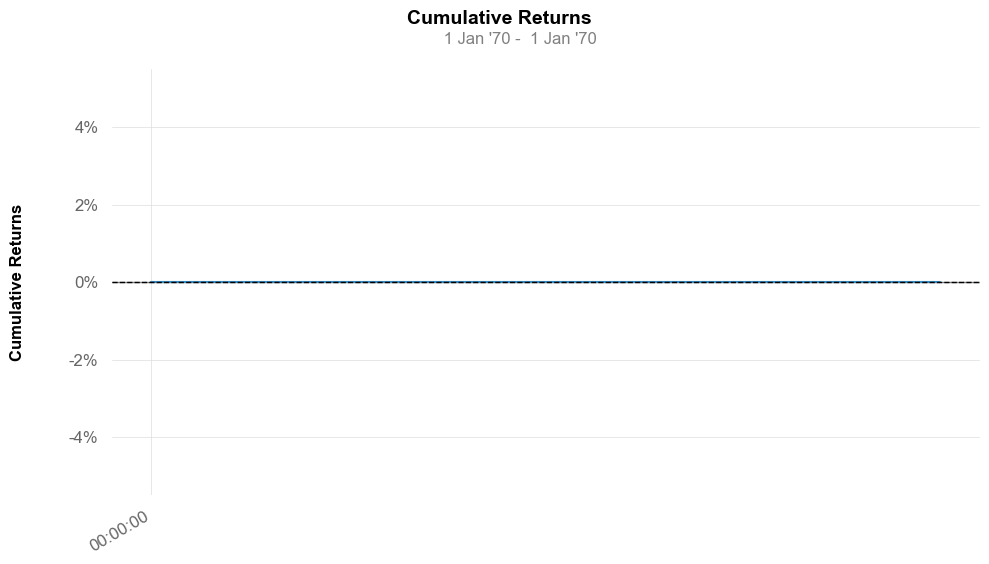

In [19]:
import quantstats as qs
import numpy as np
import pandas as pd

# Generate returns array with all zeros for demonstration
returns = np.zeros(252)

# Convert NumPy array to Pandas Series
returns_series = pd.Series(returns)

# Convert the index to datetime
returns_series.index = pd.to_datetime(returns_series.index)

# Calculate and print performance metrics
qs.extend_pandas()

# Check if the total return is zero
if np.sum(returns) == 0:
    print("Total return is zero. CAGR calculation not applicable.")
else:
    metrics = qs.reports.metrics(returns_series)
    print(metrics)

print(returns_series)
print(type(returns_series))
# Visualize returns
qs.plots.returns(returns_series)
